In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Introduction

In this chapter, we will use Game of Thrones as a case study to practice our newly learnt skills of network analysis.

It is suprising right? What is the relationship between a fatansy TV show/novel and network science or Python(not dragons).

If you haven't heard of Game of Thrones, then you must be really good at hiding. Game of Thrones is a hugely popular television series by HBO based on the (also) hugely popular book series A Song of Ice and Fire by George R.R. Martin. In this notebook, we will analyze the co-occurrence network of the characters in the Game of Thrones books. Here, two characters are considered to co-occur if their names appear in the vicinity of 15 words from one another in the books.

The figure below is a precusor of what we will analyse in this chapter.

![](../../images/got.png)


The dataset is publicly avaiable for the 5 books at https://github.com/mathbeveridge/asoiaf. This is an interaction network and were created by connecting two characters whenever their names (or nicknames) appeared within 15 words of one another in one of the books. The edge weight corresponds to the number of interactions. 


Data and figure Credits:

Blog: https://networkofthrones.wordpress.com

Math Horizons Article: https://www.maa.org/sites/default/files/pdf/Mathhorizons/NetworkofThrones%20%281%29.pdf

In [113]:
import pandas as pd
import networkx as nx
import community
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

In [33]:
books = pd.read_csv('../../datasets/game_of_thrones_network/asoiaf.csv', index_col='id')

The resulting DataFrame books has 5 columns: Source, Target, Type, weight, and book. Source and target are the two nodes that are linked by an edge. As we know a network can have directed or undirected edges and in this network all the edges are undirected. The weight attribute of every edge tells us the number of interactions that the characters have had over the book, and the book column tells us the book number.

Let's have a look at the data.

In [252]:
# We also add this weight_inv to our dataset. Why? we will discuss it a later section.
books['weight_inv'] = 1/books.weight

In [253]:
books.head()

,Source,Target,Type,weight,book,weight_inv
id,,,,,,
0,Addam-Marbrand,Jaime-Lannister,Undirected,3,1.0,0.333333
1,Addam-Marbrand,Tywin-Lannister,Undirected,6,1.0,0.166667
2,Aegon-I-Targaryen,Daenerys-Targaryen,Undirected,5,1.0,0.200000
3,Aegon-I-Targaryen,Eddard-Stark,Undirected,4,1.0,0.250000
4,Aemon-Targaryen-(Maester-Aemon),Alliser-Thorne,Undirected,4,1.0,0.250000


From the above data we can see that the characters Addam Marbrand and Tywin Lannister have interacted 6 times in the first book.

We can investigate this data by using the pandas DataFrame. Let's find all the interactions of Robb Stark in the third book.

In [254]:
books[(books.book == 3.0) &                               # select book 3
      ((books.Source == 'Robb-Stark') |                   # as these are undirected edges we need to check both
       (books.Target == 'Robb-Stark'))].head()            # source and target

,Source,Target,Type,weight,book,weight_inv
id,,,,,,
1468,Aegon-Frey-(son-of-Stevron),Robb-Stark,Undirected,5,3.0,0.200000
1582,Arya-Stark,Robb-Stark,Undirected,14,3.0,0.071429
1604,Balon-Greyjoy,Robb-Stark,Undirected,6,3.0,0.166667
1677,Bran-Stark,Robb-Stark,Undirected,18,3.0,0.055556
1683,Brandon-Stark,Robb-Stark,Undirected,3,3.0,0.333333


As you can see this data easily translates to a network problem. Now it's time to create a network.
We create a graph for each book. It's possible to create one `MultiGraph`(Graph with multiple edges between nodes) instead of 5 graphs, but it is easier to analyse and manipulate individual `Graph` objects rather than a `MultiGraph`.

In [255]:
# example of creating a MultiGraph

# all_books_multigraph = nx.from_pandas_edgelist(books, source='Source', target='Target',
#                                                edge_attr=['weight', 'book'], create_using=nx.MultiGraph)

In [256]:
# we create a list of graph objects using nx.from_pandas_edgelist and specifying the attributes we want to include
graphs = [nx.from_pandas_edgelist(books[books.book==i],
                                  source='Source', target='Target',
                                  edge_attr=['weight', 'weight_inv'])
          for i in range(1, 6)]

In [258]:
# The Graph object associated with the first book.
graphs[0]

In [259]:
# To access the relationship edges in the graph with the edge attribute weight data (data=True)
relationships = list(graphs[0].edges(data=True))

In [261]:
relationships[0:3]

[('Addam-Marbrand',
  'Jaime-Lannister',
  {'weight': 3, 'weight_inv': 0.3333333333333333}),
 ('Addam-Marbrand',
  'Tywin-Lannister',
  {'weight': 6, 'weight_inv': 0.16666666666666666}),
 ('Jaime-Lannister', 'Aerys-II-Targaryen', {'weight': 5, 'weight_inv': 0.2})]

## Finding the most important node i.e character in these networks.

Let's use our network analysis knowledge to decrypt these Graphs that we have just created.

Is it Jon Snow, Tyrion, Daenerys, or someone else? Let's see! Network Science offers us many different metrics to measure the importance of a node in a network as we saw in the first part of the tutorial. Note that there is no "correct" way of calculating the most important node in a network, every metric has a different meaning.

First, let's measure the importance of a node in a network by looking at the number of neighbors it has, that is, the number of nodes it is connected to. For example, an influential account on Twitter, where the follower-followee relationship forms the network, is an account which has a high number of followers. This measure of importance is called degree centrality.

Using this measure, let's extract the top ten important characters from the first book (`graphs[0]`) and the fifth book (`graphs[4]`).

NOTE: We are using zero-indexing and that's why the graph of the first book is acceseed by `graphs[0]`.

In [262]:
# We use the in-built degree_centrality method provided by networkx
deg_cen_book1 = nx.degree_centrality(graphs[0])
deg_cen_book5 = nx.degree_centrality(graphs[4])

In [263]:
# degree_centrality returns a dictionary and to access the results we can directly use the name of the Character

deg_cen_book1['Daenerys-Targaryen']

0.11290322580645162

In [264]:
# The following expression sorts the dictionary by degree centrality and returns the top 5 from a graph

sorted(deg_cen_book1.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Eddard-Stark', 0.3548387096774194),
 ('Robert-Baratheon', 0.2688172043010753),
 ('Tyrion-Lannister', 0.24731182795698928),
 ('Catelyn-Stark', 0.23118279569892475),
 ('Jon-Snow', 0.19892473118279572)]

In [265]:
sorted(deg_cen_book5.items(), key=lambda x:x[1], reverse=True)[0:5]

[('Jon-Snow', 0.1962025316455696),
 ('Daenerys-Targaryen', 0.18354430379746836),
 ('Stannis-Baratheon', 0.14873417721518986),
 ('Tyrion-Lannister', 0.10443037974683544),
 ('Theon-Greyjoy', 0.10443037974683544)]

To visualize the distribution of degree centrality let's plot a histogram of degree centrality.

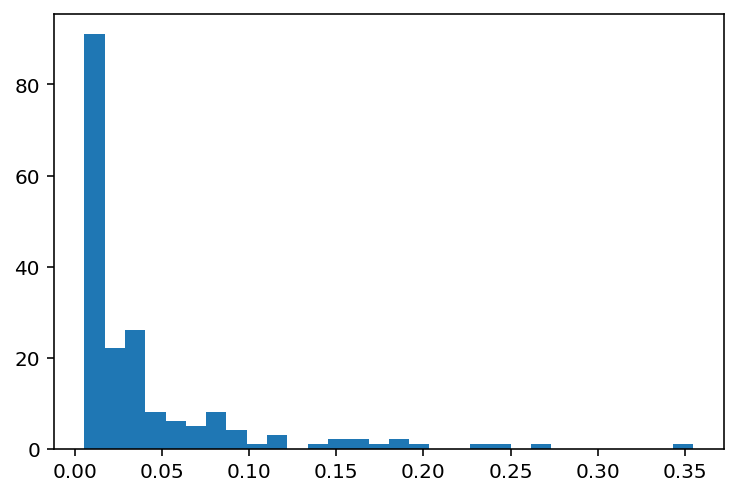

In [266]:
plt.hist(deg_cen_book1.values(), bins=30)
plt.show()

The above plot shows something that is expected, a high portion of characters aren't connected to lot of other characters while some characters are highly connected all through the network. A close real world example of this is a social network like Twitter where a few people have millions of connections(followers) but majority of users aren't connected to that many other users. This exponential decay like property resembles power law in real life networks.

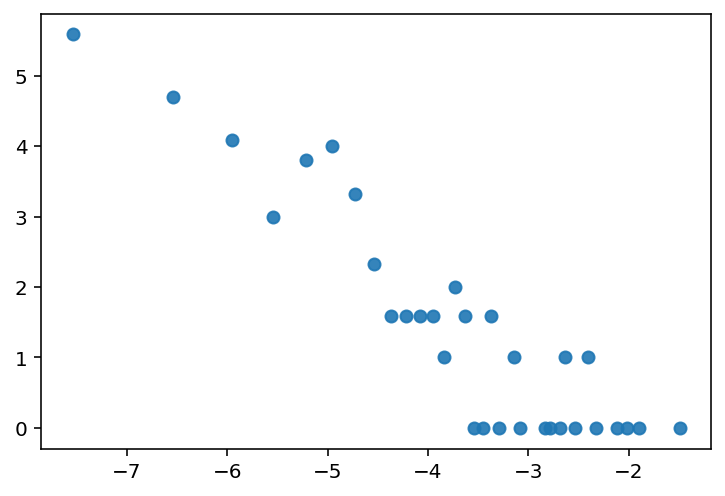

In [267]:
# A log-log plot to show the "signature" of power law in graphs.
from collections import Counter
hist = Counter(deg_cen_book1.values())
plt.scatter(np.log2(list(hist.keys())), np.log2(list(hist.values())), alpha=0.9)
plt.show()

### Exercise

Create a new centrality measure, weighted_degree(Graph, weight) which takes in Graph and the weight attribute and returns a weighted degree dictionary. Weighted degree is calculated by summing the weight of the all edges of a node and find the top five characters according to this measure.

In [268]:
from nams.solutions.got import weighted_degree

plt.hist(list(weighted_degree(graphs[0], 'weight').values()), bins=30)
plt.show()

ModuleNotFoundError: No module named 'nams'

In [185]:
sorted(weighted_degree(graphs[0], 'weight').items(), key=lambda x:x[1], reverse=True)[0:5]

[('Eddard-Stark', 1284),
 ('Robert-Baratheon', 941),
 ('Jon-Snow', 784),
 ('Tyrion-Lannister', 650),
 ('Sansa-Stark', 545)]

## Betweeness centrality

Let's do this for Betweeness centrality and check if this makes any difference. As different centrality method use different measures underneath, they find nodes which are important in the network. A centrality method like Betweeness centrality finds nodes which are structurally important to the network, which binds the network together and densely.

In [269]:
# First check unweighted (just the structure)

sorted(nx.betweenness_centrality(graphs[0]).items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.2696038913836117),
 ('Robert-Baratheon', 0.21403028397371796),
 ('Tyrion-Lannister', 0.1902124972697492),
 ('Jon-Snow', 0.17158135899829566),
 ('Catelyn-Stark', 0.1513952715347627),
 ('Daenerys-Targaryen', 0.08627015537511595),
 ('Robb-Stark', 0.07298399629664767),
 ('Drogo', 0.06481224290874964),
 ('Bran-Stark', 0.05579958811784442),
 ('Sansa-Stark', 0.03714483664326785)]

In [270]:
# Let's care about interactions now

sorted(nx.betweenness_centrality(graphs[0], weight='weight_inv').items(), key=lambda x:x[1], reverse=True)[0:10]

[('Eddard-Stark', 0.5926474861958733),
 ('Catelyn-Stark', 0.36855565242662014),
 ('Jon-Snow', 0.3514094739901191),
 ('Robert-Baratheon', 0.3329991281604185),
 ('Tyrion-Lannister', 0.27137460040685846),
 ('Daenerys-Targaryen', 0.202615518744551),
 ('Bran-Stark', 0.0945655332752107),
 ('Robb-Stark', 0.09177564661435629),
 ('Arya-Stark', 0.06939843068875327),
 ('Sansa-Stark', 0.06870095902353966)]

In [ ]:
We can see there are some differences between the unweighted and weighted centrality measures. The weight